In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.interpolate import griddata
from utilities.common_functions import clean_dataframe, create_historical_dataframe
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Exploring with station 44013
coordinates = [42.346, -70.651]
nc_file = 'ERA5/Processed/era5_2019_-83_-65_37_49.nc'

In [3]:
def load_era5(nc_file):
    dataset = xr.open_dataset(nc_file)
    # Convert the dataset to a pandas DataFrame
    df = dataset.to_dataframe()
    # Reset index to move time, latitude, and longitude from index to columns
    df_reset = df.reset_index()
    return df_reset

In [4]:
def find_four_closest_points(df_reset, coordinates):
    # Compute the Euclidean distance between each point and the target
    df_reset["distance"] = np.sqrt((df_reset['latitude'] - coordinates[0])**2 + (df_reset['longitude'] - coordinates[1])**2)
    # sort the dataframe by time and distance
    df_sorted = df_reset.sort_values(by=['time', 'distance'])
    
    # keep the four first rows for each time
    df_sorted = df_sorted.groupby('time').head(4)
    return df_sorted


In [5]:
def linear_interpolation(dataset, coordinates):
    points = dataset[['latitude', 'longitude']][:4].values
    interpolated_df_value = pd.DataFrame(columns=['time','u_interp', 'v_interp', 'ssr_interp', 't2m_interp', 'd2m_interp'])
    nb_values = len(dataset)
    
    # create a matrix with the batch of 4 points with the values of u
    u_values = dataset['u10'].values
    v_values = dataset['v10'].values
    ssr_values = dataset['ssr'].values
    t2m_values = dataset['t2m'].values
    d2m_values = dataset['d2m'].values
    u_matrix = u_values[:nb_values // 4 * 4].reshape(-1, 4).T
    v_matrix = v_values[:nb_values // 4 * 4].reshape(-1, 4).T
    ssr_matrix = ssr_values[:nb_values // 4 * 4].reshape(-1, 4).T
    t2m_matrix = t2m_values[:nb_values // 4 * 4].reshape(-1, 4).T
    d2m_matrix = d2m_values[:nb_values // 4 * 4].reshape(-1, 4).T
    
    
    # Define an interpolation function
    def interpolate_column(col):
        return griddata(points, col, (coordinates[0], coordinates[1]), method='linear')

    # Apply the interpolation function to each column of the matrices
    interpolated_df_value['u_interp'] = np.apply_along_axis(interpolate_column, 0, u_matrix)
    interpolated_df_value['v_interp'] = np.apply_along_axis(interpolate_column, 0, v_matrix)
    interpolated_df_value['ssr_interp'] = np.apply_along_axis(interpolate_column, 0, ssr_matrix)
    interpolated_df_value['t2m_interp'] = np.apply_along_axis(interpolate_column, 0, t2m_matrix)
    interpolated_df_value['d2m_interp'] = np.apply_along_axis(interpolate_column, 0, d2m_matrix)
    interpolated_df_value['time'] = dataset['time'].unique()
    
    
    
    

    return interpolated_df_value
    

In [6]:
def time_interpolating_dataset(interpolate_df):
    # interpolate between two times
    start_time = interpolate_df['time'].min()
    end_time = interpolate_df['time'].max()

    # Create a time range starting at the first occurrence of `00:50`, and repeating every hour
    new_times = pd.date_range(start=start_time + pd.Timedelta(minutes=50), 
                            end=end_time + pd.Timedelta(hours=1), 
                            freq='h')

    interpolate_df.set_index('time', inplace=True)
    # Reindex the original dataframe to include new times
    df_reindexed = interpolate_df.reindex(interpolate_df.index.union(new_times))


    # Interpolate the missing values
    df_time_interpolated = df_reindexed.interpolate(method='time')
    
    return df_time_interpolated
    

In [25]:
def process_buoy_data(station_name, year):
    # Load the buoy data
    dataframe = pd.DataFrame()
    dataframe = create_historical_dataframe(station_name, year, dataframe)
    dataframe = clean_dataframe(dataframe)
    dataframe['u_velocity'] = dataframe['WDIR'].apply(lambda x: np.cos(np.radians(270 - x))) * dataframe['WSPD']
    dataframe['v_velocity'] = dataframe['WDIR'].apply(lambda x: np.sin(np.radians(270 - x))) * dataframe['WSPD']
    dataframe['ATMP'] = dataframe['ATMP'] + 273.15
    dataframe['DEWP'] = dataframe['DEWP'] + 273.15
    return dataframe

In [8]:
dataset = load_era5(nc_file)

In [9]:
dataset = find_four_closest_points(dataset, coordinates)

In [10]:
interpolate_df = linear_interpolation(dataset, coordinates)

In [11]:
df_time_interpolated = time_interpolating_dataset(interpolate_df)

In [26]:
buoy_dataframe = process_buoy_data('44013', 2019)

/Users/matteopeduto/Documents/GitHub/master_thesis/offshore-wind-forecasting/utilities/common_functions.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/downloaded_historical_file_{station_number}_{year}.txt', delim_whitespace=True, skiprows=1)


In [27]:
comparative_dataset = pd.merge(buoy_dataframe, df_time_interpolated, left_index=True, right_index=True, how='inner')

In [28]:
comparative_dataset

,WDIR,WSPD,GST,PRES,ATMP,DEWP,u_velocity,v_velocity,u_interp,v_interp,ssr_interp,t2m_interp,d2m_interp
2019-01-01 00:50:00,158,9.6,11.5,1023.7,276.75,274.65,-3.596223,8.900965,-2.259404,7.786121,3.599999e-12,277.158357,273.745434
2019-01-01 01:50:00,136,10.6,12.3,1021.0,277.25,274.85,-7.363379,7.625002,-4.218832,8.244022,3.599999e-12,276.649643,274.512652
2019-01-01 02:50:00,143,11.1,13.3,1019.3,277.25,275.75,-6.680147,8.864854,-3.681302,10.249026,3.599999e-12,277.084197,274.854026
2019-01-01 03:50:00,139,12.3,14.6,1017.3,277.35,276.45,-8.069526,9.282928,-4.420316,10.291170,3.599999e-12,277.214283,275.466354
2019-01-01 04:50:00,133,12.3,15.6,1014.8,278.15,277.55,-8.995651,8.388580,-5.078977,10.529627,3.599999e-12,278.307426,275.994078
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 18:50:00,330,6.9,8.4,999.3,276.25,276.25,3.450000,-5.975575,2.687589,-7.208967,7.825286e+05,277.473914,275.888071
2019-12-31 19:50:00,329,5.6,7.2,999.5,276.35,276.35,2.884213,-4.800137,4.002990,-4.972232,4.673900e+05,277.425015,275.524863
2019-12-31 20:50:00,294,4.0,5.6,1000.4,276.25,276.25,3.654182,-1.626947,4.966479,-3.297315,1.320418e+05,277.544961,275.307733
2019-12-31 21:50:00,328,3.8,5.2,999.6,276.05,275.85,2.013693,-3.222583,3.144258,-2.899629,1.466244e+04,277.276561,275.167599


In [29]:
# Correlation between ERA5 velocity and buoy velocity
correlation_u = comparative_dataset['u_velocity'].corr(comparative_dataset['u_interp'])
correlation_v = comparative_dataset['v_velocity'].corr(comparative_dataset['v_interp'])
correlation_dewp = comparative_dataset['DEWP'].corr(comparative_dataset['d2m_interp'])
correlation_t2m = comparative_dataset['ATMP'].corr(comparative_dataset['t2m_interp'])


In [32]:
def visualize_correlation(dataset, variable_1, variable_2, variable_type, correlation):
    
    
    # Visualization 1: Scatter plot with regression line
    plt.figure(figsize=(8, 6))
    sns.regplot(x=variable_1, y=variable_2, data=dataset)
    # add an x=y line
    x = np.linspace(dataset[variable_1].min(), dataset[variable_1].max(), 100)
    plt.plot(x, x, 'k--')
    plt.plot
    plt.title(f'Scatter Plot of {variable_type} (ERA5 vs Buoy) - Correlation: {correlation:.2f}')
    plt.xlabel(f'{variable_1} (ERA5)')
    plt.ylabel(f'{variable_2} (Buoy)')
    plt.show()

    # Visualization 2: Time-series comparison
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset[variable_1], label=f'ERA5 {variable_1}', marker='o')
    plt.plot(dataset.index, dataset[variable_2], label=f'Buoy {variable_2}', marker='x')
    plt.title(f'Time Series of {variable_2} vs {variable_1} (ERA5 vs Buoy)')
    plt.xlabel('Time')
    plt.ylabel(f'{variable_type}')
    plt.legend()
    plt.show()

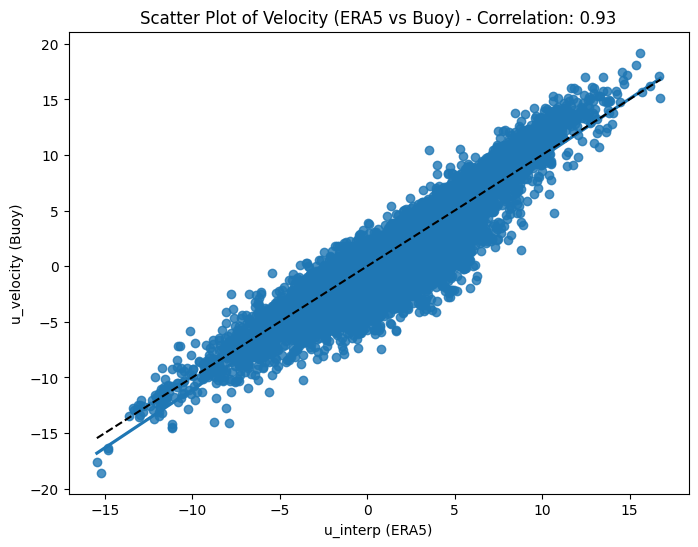

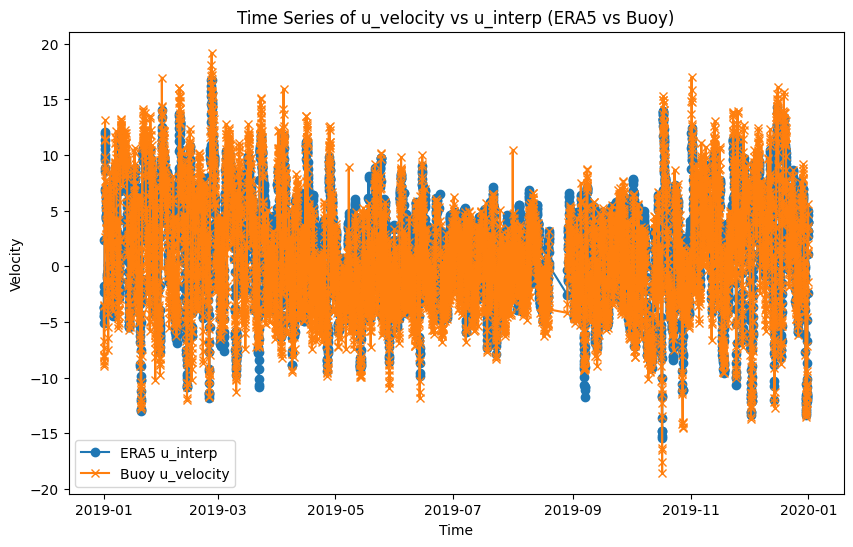

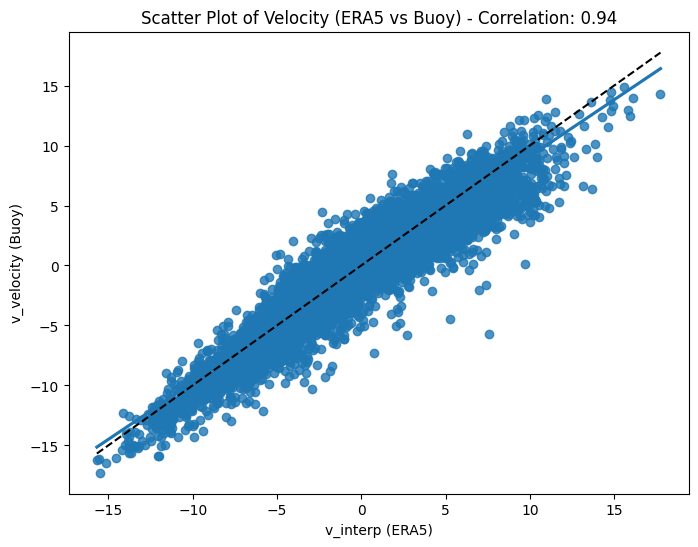

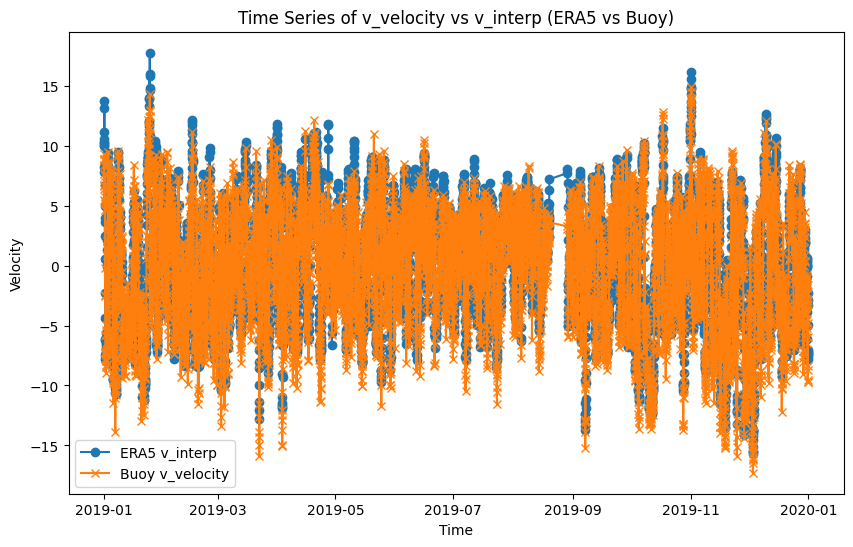

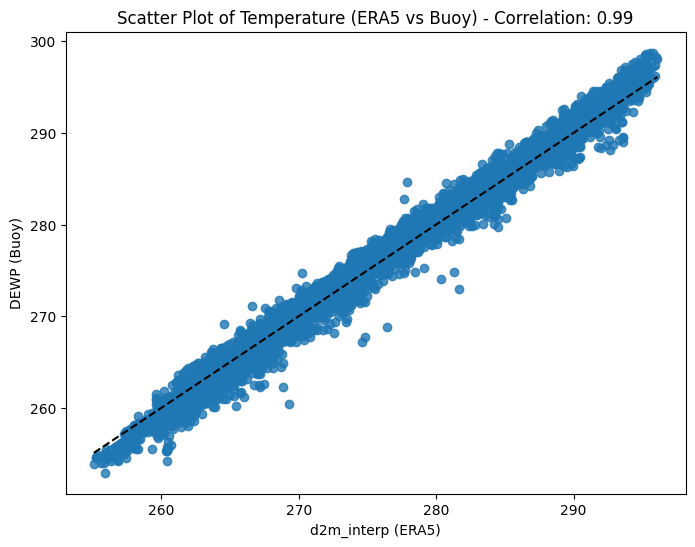

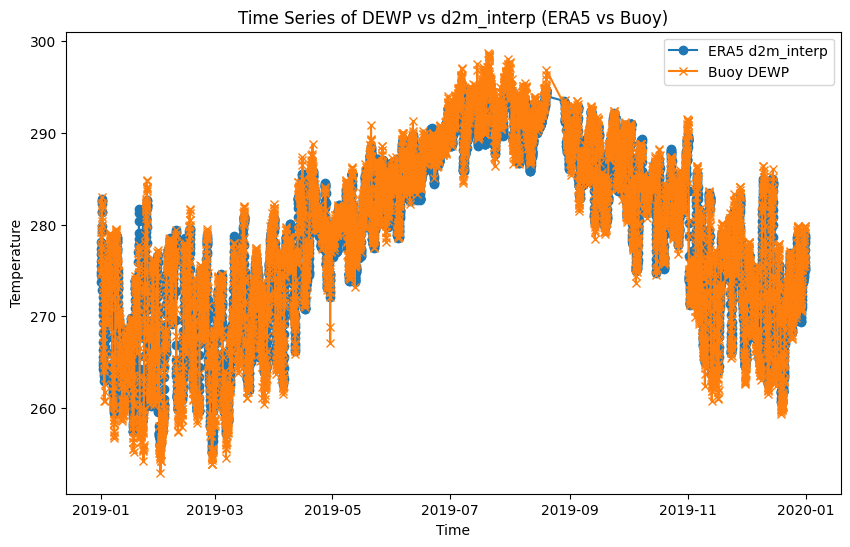

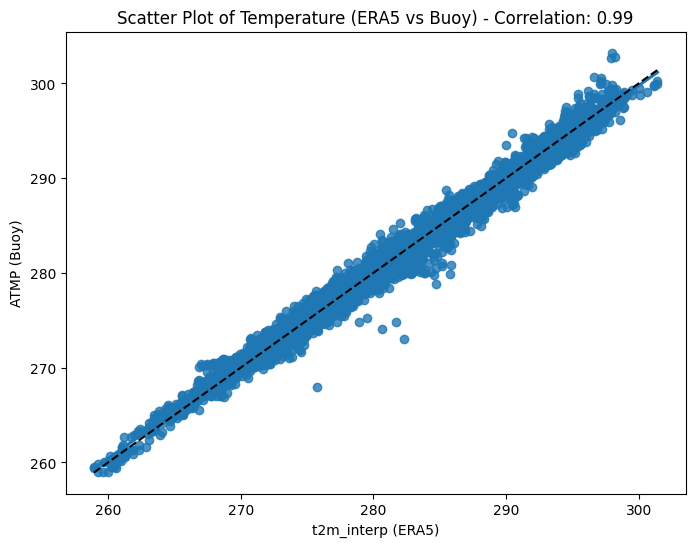

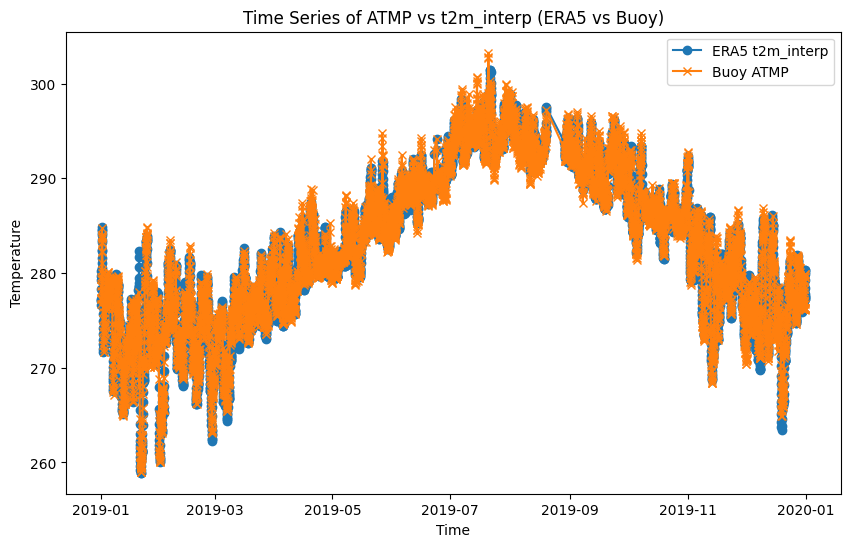

In [33]:
visualize_correlation(comparative_dataset, 'u_interp', 'u_velocity', 'Velocity', correlation_u)
visualize_correlation(comparative_dataset, 'v_interp', 'v_velocity', 'Velocity', correlation_v)
visualize_correlation(comparative_dataset, 'd2m_interp', 'DEWP', 'Temperature', correlation_dewp)
visualize_correlation(comparative_dataset, 't2m_interp', 'ATMP', 'Temperature', correlation_t2m)


In [ ]:
file = 'A01_met_all_4c4d_7d6d_ac7a.nc'

dataframe = load_era5(file)

In [ ]:
dataframe.columns

In [ ]:
dataframe


In [ ]:
dataframe.drop(columns=['wind_2_gust', 'wind_2_gust_qc',
       'wind_2_speed', 'wind_2_speed_qc', 'wind_2_direction',
       'wind_2_direction_qc'], inplace=True)

In [ ]:
dataframe